## X-Ray Predictive Analytics for Pneumonia Diagnosis Utilizing AI and Big Data

### Importing required libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

### Initiating spark session for image pre-processing

In [5]:
from pyspark.sql import SparkSession
from PIL import Image
import io

In [3]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Image pre-Processing") \
    .config("spark.master", "local[*]") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.network.timeout", "600s") \
    .config("spark.sql.broadcastTimeout", "1200") \
    .config("spark.task.maxFailures", "10") \
    .getOrCreate()


# Define labels and image size
labels = ['Normal', 'Pneumonia']
img_size = 200

def preprocess_image(content):
    # Opens an image and converts it to greyscale and resizes it
    image = Image.open(io.BytesIO(content))
    image = image.resize((img_size, img_size)).convert('L')
    return np.array(image).reshape(img_size, img_size, 1)

def process_images(image_rdd, label):
    # Filters files based on label and preprocesses them
    filtered_images = image_rdd.filter(lambda file: label in file[0])
    return filtered_images.map(lambda img: (label, preprocess_image(img[1])))

def save_as_object_files(processed_images, output_dir):
    # Saves processed images as object files in HDFS
    for label, images in processed_images.items():
        images.saveAsPickleFile(f"{output_dir}/{label}_new")

# Defining paths for training, testing, and validation datasets
paths = {
    "train": "hdfs://localhost:9000/xrays/train/*/*.jpeg",
    "test": "hdfs://localhost:9000/xrays/test/*/*.jpeg",
    "val": "hdfs://localhost:9000/xrays/val/*/*.jpeg"
}

processed_data = {}
for dtype, path in paths.items():
    image_rdd = spark.sparkContext.binaryFiles(path)
    processed_images = {label: process_images(image_rdd, label) for label in labels}
    save_as_object_files(processed_images, f"pro_{dtype}")

spark.stop()


### Displaying Sample image from each label

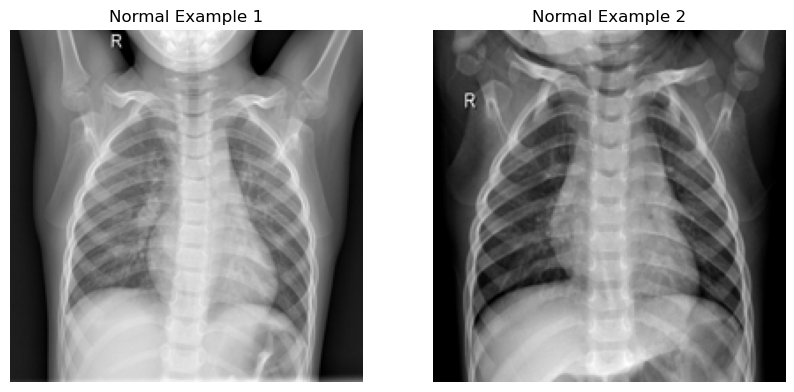

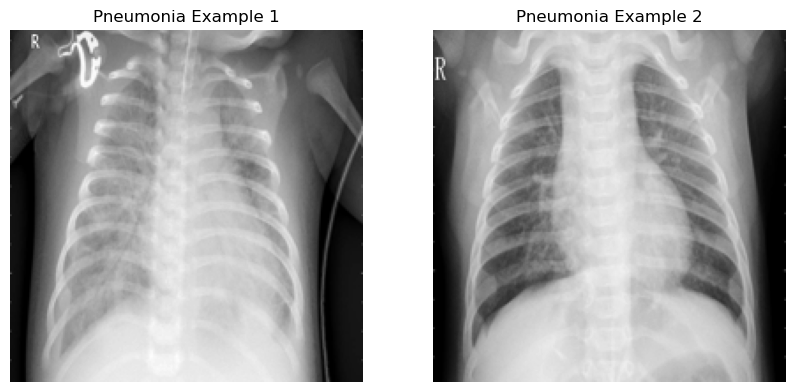

In [7]:
# Initializing Spark session for displaying image
spark = SparkSession.builder \
    .appName("Image Display") \
    .config("spark.master", "local[*]") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()

def load_and_display_images(directory, label, num_images=2):
    path = f"{directory}/{label}_new"
    
    # Loading the images
    rdd = spark.sparkContext.pickleFile(path)
    
    # Taking a few images for display
    images = rdd.take(num_images)
    
    # Displays the images
    fig, axs = plt.subplots(1, num_images, figsize=(10, 5))
    for i, img in enumerate(images):
        axs[i].imshow(img[1].squeeze(), cmap='gray')  # img[1] because it's a tuple (label, image_array)
        axs[i].set_title(f"{label} Example {i+1}")
        axs[i].axis('off')
    plt.show()

# Specifying the base directory where images are stored
base_directory = "hdfs://localhost:9000/user/affuk/pro_train"

# Displaying images for both labels
load_and_display_images(base_directory, "Normal")
load_and_display_images(base_directory, "Pneumonia")

spark.stop()

### Image processing

In [6]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Image Processing") \
    .config("spark.master", "local[*]") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()

def preprocess_image(content):
    image = Image.open(io.BytesIO(content))
    image = image.resize((200, 200)).convert('L')  # Resizng and convert to grayscale
    return np.array(image).reshape(200, 200, 1)  # Reshaping for consistency

def load_and_process_data(path, label):
    image_rdd = spark.sparkContext.binaryFiles(path)
    processed_images = image_rdd.map(lambda file_content: preprocess_image(file_content[1])).collect()
    labels = [0 if label == 'Normal' else 1] * len(processed_images)
    return np.array(processed_images), np.array(labels)

# Defining paths for datasets
dataset_paths = {
    'Normal': {
        'train': "hdfs://localhost:9000/xrays/train/Normal/*.jpeg",
        'val': "hdfs://localhost:9000/xrays/val/Normal/*.jpeg",
        'test': "hdfs://localhost:9000/xrays/test/Normal/*.jpeg"
    },
    'Pneumonia': {
        'train': "hdfs://localhost:9000/xrays/train/Pneumonia/*.jpeg",
        'val': "hdfs://localhost:9000/xrays/val/Pneumonia/*.jpeg",
        'test': "hdfs://localhost:9000/xrays/test/Pneumonia/*.jpeg"
    }
}

# Load and process all datasets
X_train_normal, y_train_normal = load_and_process_data(dataset_paths['Normal']['train'], 'Normal')
X_train_pneumonia, y_train_pneumonia = load_and_process_data(dataset_paths['Pneumonia']['train'], 'Pneumonia')

# Upsampling the Normal class
upsample_size = len(y_train_pneumonia) - len(y_train_normal)
upsampled_normal_indices = np.random.choice(np.arange(len(y_train_normal)), size=upsample_size, replace=True)
X_train_normal_upsampled = X_train_normal[upsampled_normal_indices]
y_train_normal_upsampled = y_train_normal[upsampled_normal_indices]

# Combining and shuffling the training data
X_train = np.vstack([X_train_normal, X_train_pneumonia, X_train_normal_upsampled])
y_train = np.hstack([y_train_normal, y_train_pneumonia, y_train_normal_upsampled])

# Shuffling the dataset
shuffle_indices = np.random.permutation(len(X_train))
X_train = X_train[shuffle_indices]
y_train = y_train[shuffle_indices]

# Loading validation and test data
X_val, y_val = np.vstack([
    load_and_process_data(dataset_paths['Normal']['val'], 'Normal')[0],
    load_and_process_data(dataset_paths['Pneumonia']['val'], 'Pneumonia')[0]
]), np.hstack([
    load_and_process_data(dataset_paths['Normal']['val'], 'Normal')[1],
    load_and_process_data(dataset_paths['Pneumonia']['val'], 'Pneumonia')[1]
])

X_test, y_test = np.vstack([
    load_and_process_data(dataset_paths['Normal']['test'], 'Normal')[0],
    load_and_process_data(dataset_paths['Pneumonia']['test'], 'Pneumonia')[0]
]), np.hstack([
    load_and_process_data(dataset_paths['Normal']['test'], 'Normal')[1],
    load_and_process_data(dataset_paths['Pneumonia']['test'], 'Pneumonia')[1]
])

# Normalizing the data
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0

# Merging training and validation data as validation data is too small
X_train, y_train = np.vstack([X_train, X_val]), np.hstack([y_train, y_val])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=32)

spark.stop()

# Output the shape of datasets to confirm
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Training data shape: (6989, 200, 200, 1) (6989,)
Validation data shape: (777, 200, 200, 1) (777,)
Test data shape: (624, 200, 200, 1) (624,)


### Data Augmentation

In [7]:
# Setting up data augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=30,  # Allows random rotations up to 30 degrees
    zoom_range=0.05,  # Allows random zoom up to 5%
    width_shift_range=0.05,  # Allows random horizontal shifts up to 5%
    height_shift_range=0.05,  # Allows random vertical shifts up to 5%
    horizontal_flip=True,  # Allows horizontal flipping
    fill_mode='nearest'  # Fills in new pixels after a rotation or width/height shift
)


# Apply the augmentation to the training data
datagen.fit(X_train)

### CNN 

In [9]:
from tensorflow.keras.regularizers import l2

# Defining the CNN model architecture with some modifications
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1), padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Flatten(),
    
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])

# Compiling the model with a potentially lower learning rate
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

C:\Users\affuk\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 200, 200, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 200, 200, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 100, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 50, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 25, 25, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       9,437,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,860,225 (37.61 MB)

 Trainable params: 9,859,265 (37.61 MB)

 Non-trainable params: 960 (3.75 KB)

### Training the model

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callback for early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Callback for saving the best model during training
model_checkpoint = ModelCheckpoint(
    'best_model.keras',  # Updated file extension to .keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


# Callback for reducing the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Train the model using the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20,  
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    class_weight=class_weights_dict, 
    verbose=2
)

Epoch 1/20


C:\Users\affuk\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 10.98748, saving model to best_model.keras
219/219 - 259s - 1s/step - accuracy: 0.8466 - loss: 1.0994 - val_accuracy: 0.5122 - val_loss: 10.9875 - learning_rate: 1.0000e-04
Epoch 2/20

Epoch 2: val_loss improved from 10.98748 to 4.29818, saving model to best_model.keras
219/219 - 256s - 1s/step - accuracy: 0.9073 - loss: 0.8630 - val_accuracy: 0.5122 - val_loss: 4.2982 - learning_rate: 1.0000e-04
Epoch 3/20

Epoch 3: val_loss improved from 4.29818 to 0.70560, saving model to best_model.keras
219/219 - 256s - 1s/step - accuracy: 0.9250 - loss: 0.7662 - val_accuracy: 0.9434 - val_loss: 0.7056 - learning_rate: 1.0000e-04
Epoch 4/20

Epoch 4: val_loss improved from 0.70560 to 0.59899, saving model to best_model.keras
219/219 - 266s - 1s/step - accuracy: 0.9326 - loss: 0.6986 - val_accuracy: 0.9511 - val_loss: 0.5990 - learning_rate: 1.0000e-04
Epoch 5/20

Epoch 5: val_loss improved from 0.59899 to 0.55653, saving model to best_model.keras
219/219 - 2

### Evaluating Training Model

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step


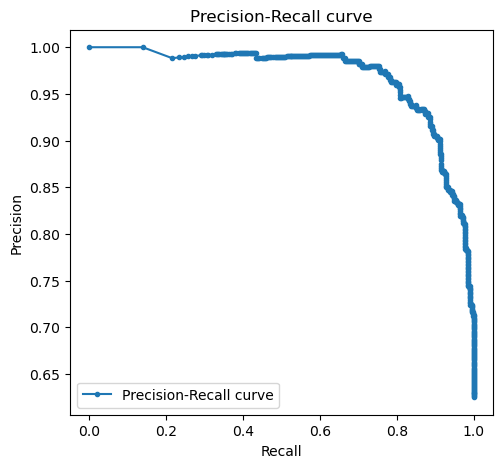

In [12]:
predictions = model.predict(X_test)

# Calculating Precision and Recall values
precisions, recalls, thresholds = precision_recall_curve(y_test, predictions)

# Plotting Precision-Recall Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(recalls, precisions, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()

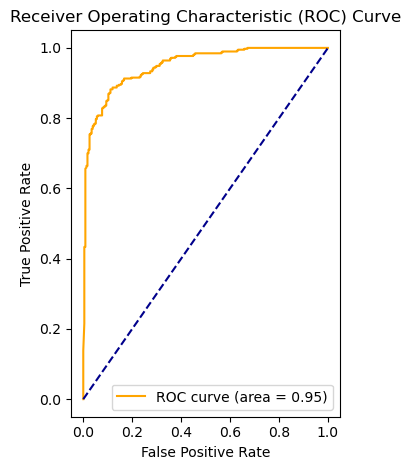

In [14]:
from sklearn.metrics import auc

# Calculating the FPR and TPR for the ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

plt.tight_layout()
plt.show()

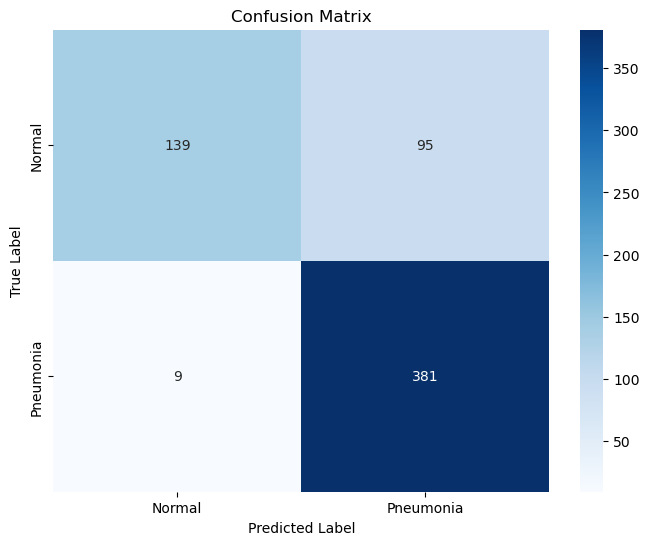

In [15]:
# Generating binary predictions based on the probability output and a threshold
binary_predictions = (predictions > 0.5).astype(int)

# Creating the confusion matrix
cm = confusion_matrix(y_test, binary_predictions)
class_labels = ['Normal', 'Pneumonia']

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, binary_predictions, target_names=class_labels))

              precision    recall  f1-score   support

      Normal       0.94      0.59      0.73       234
   Pneumonia       0.80      0.98      0.88       390

    accuracy                           0.83       624
   macro avg       0.87      0.79      0.80       624
weighted avg       0.85      0.83      0.82       624



In [20]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=1)
print(f"Training Accuracy: {train_accuracy*100:.2f}%")

219/219 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - accuracy: 0.9769 - loss: 0.1918
Training Accuracy: 97.58%


In [21]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.8333333333333334
Precision on testing set: 0.9769230769230769
Recall on testing set: 0.8004201680672269


### Printing 25 sample predictions

In [8]:
model = keras.models.load_model('pneumonia_detection_v1.keras')

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step


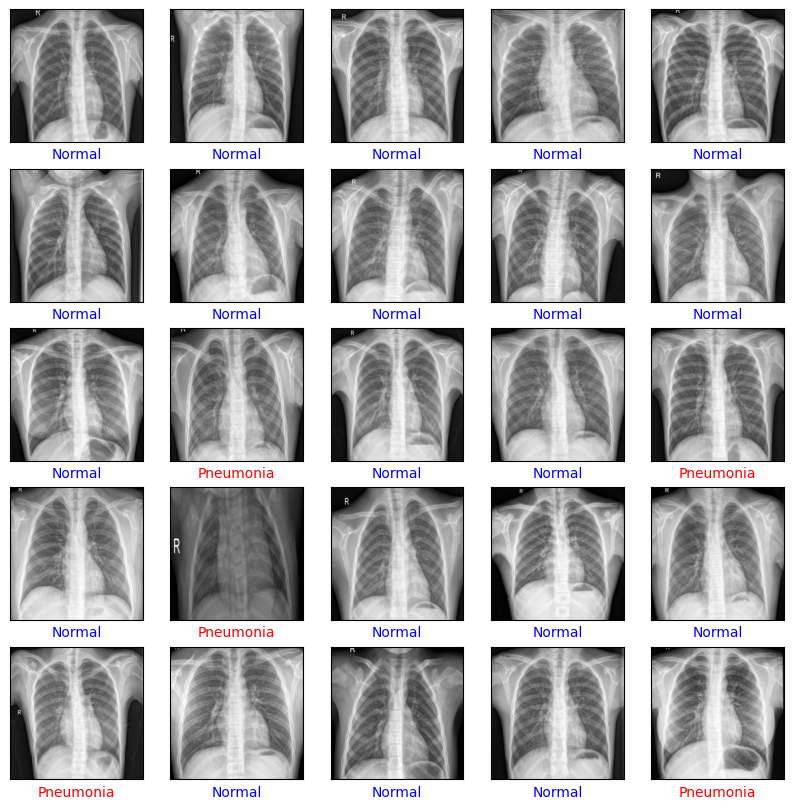

In [12]:
predictions = model.predict(X_test)
# Converting probabilities to binary predictions assuming binary classification with a threshold of 0.5
binary_predictions = (predictions > 0.5).astype(int)

# Labels for your binary classes
labels = ['Normal', 'Pneumonia']

img_size = 200 

# Visualizing the images and their predicted labels
plt.figure(figsize=(10, 10))
for i in range(25): 
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Reshape and display the image, ensure X_train is used if it's meant to be the training set
    plt.imshow(X_test[i].reshape(img_size, img_size), cmap='gray')
    # Check if prediction matches the true label
    if binary_predictions[i] == y_test[i]:
        plt.xlabel(labels[binary_predictions[i][0]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i][0]], color='red')
plt.show()

In [23]:
model.save('pneumonia_detection_v1.keras')

### Predicting with new images

In [13]:
def preprocess_image(image_path):
    with open(image_path, 'rb') as f:
        content = f.read()
    
    image = Image.open(io.BytesIO(content))
    image = image.resize((200, 200)).convert('L')
    image_array = np.array(image) / 255.0
    image_array = image_array.reshape((1, 200, 200, 1))  # Reshape for model (adding batch dimension)
    return image_array

def predict_image(image_path, model):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)
    return prediction

# Path to the new image
image_path = "C:/Users/affuk/Desktop/GP/normal.jpeg"

prediction = predict_image(image_path, model)

# Output prediction
if prediction[0, 0] >= 0.5:
    print("The image is predicted to be Pneumonia.")
else:
    print("The image is predicted to be Normal.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
The image is predicted to be Normal.


In [14]:
def preprocess_image(image_path):
    with open(image_path, 'rb') as f:
        content = f.read()
    
    image = Image.open(io.BytesIO(content))
    image = image.resize((200, 200)).convert('L')
    image_array = np.array(image) / 255.0
    image_array = image_array.reshape((1, 200, 200, 1))  # Reshape for model (adding batch dimension)
    return image_array

def predict_image(image_path, model):
    processed_image = preprocess_image(image_path)
    prediction = model.predict(processed_image)
    return prediction

# Path to the new image
image_path = "C:/Users/affuk/Desktop/GP/pneumonia.jpeg"

prediction = predict_image(image_path, model)

# Output prediction
if prediction[0, 0] >= 0.5:
    print("The image is predicted to be Pneumonia.")
else:
    print("The image is predicted to be Normal.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
The image is predicted to be Pneumonia.
